In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Load preds

In [2]:
import json

RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_beam8-4_coherence_icl20_nohistory_20240815204213/outputs_val.json"
METRICS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_beam8-4_coherence_icl20_nohistory_20240815204213/metrics_coherence_nli_val.json"
preds = json.load(open(RESULTS_PATH, "r"))
coherence_metrics = json.load(open(METRICS_PATH, "r"))

# Look at cases with low relevance high informativeness

In [18]:
low_rel_low_info = []
low_rel_high_info = []
high_rel_low_info = []
high_rel_high_info = []

for output in preds.values():
    for question_idx in range(output['final_turn'] + 1):
        question = output['questions'][question_idx]
        answer = output['answers'][question_idx]
        selected_candidate_idx = output['candidate_questions'][question_idx].index(question)
        relevance = output['candidate_questions_scores'][question_idx][selected_candidate_idx]['relevance']
        informativeness = output['candidate_questions_scores'][question_idx][selected_candidate_idx]['informativeness_marginal']
        
        if relevance <= 0.2 and informativeness <= 0.2:
            low_rel_low_info.append((output['procedure'], question, answer))
        elif relevance <= 0.2 and informativeness >= 0.9:
            low_rel_high_info.append((output['procedure'], question, answer))
        elif relevance >= 0.9 and informativeness <= 0.2:
            high_rel_low_info.append((output['procedure'], question, answer))
        elif relevance >= 0.9 and informativeness >= 0.9:
            high_rel_high_info.append((output['procedure'], question, answer))
        
    

In [19]:
from travel.data.vqa import VQAResponse

from pprint import pprint

for procedure, question, answer in low_rel_high_info:
    print(f"{procedure} -> {question} {VQAResponse(answer).name}")

Sew the shoe with the thread and the awl in your hands -> Is the shoe in the process of being sewn? Yes
Insert the awl into the sandal -> Is the person holding the awl? Yes
Pull the thread -> Is the person holding the thread? Yes
Pull the thread -> Is the person's hand holding the thread? Yes
Clean the clay box with sand -> Is the person working on the procedure "Clean the clay box with sand"? Yes
Pick brush -> Is the person's hand holding the brush? Yes
Drop the towel on the chair -> Is the towel on the floor? No
Close the pack of sauce -> Is the pack of sauce sitting on the table? Yes
Cut a leaf with a scissor -> Are the scissors open or closed? Yes
Place the wood piece on a wall -> Is the person holding the wood piece? Yes
Remove the piece of wood from the wood cutting machine -> Is the piece of wood on the ground? Yes
Drop the bucket on the table -> Is the bucket on the ground? No
Remove the cut piece of wood from the cutting machine -> Is there a cutting machine in the image? Yes


In [14]:
from travel.data.vqa import VQAResponse

from pprint import pprint

for procedure, question, answer in high_rel_low_info:
    print(f"{procedure} -> {question} {VQAResponse(answer).name}")

In [24]:
from scipy.stats import entropy

print(entropy([0.5, 0.5], [0.4, 0.6]))


def relative_entropy(binary_prob0, binary_prob1):
    p0a = binary_prob0
    p0b = 1.0 - binary_prob0
    
    p1a = binary_prob1
    p1b = 1.0 - binary_prob1
    
    ent = np.log2(p0a/p1a)

0.020410997260127586


# Look at how max number of iterations impacts accuracy

In [36]:
from collections import defaultdict
import numpy as np

n_turns = []
success_probs_by_turn = defaultdict(list)
for output in preds.values():
    n_turns.append(output['final_turn'] + 1)
    for question_idx in range(10):
        this_question_idx = min(output['final_turn'], question_idx)
        
        question = output['questions'][this_question_idx]
        answer = output['answers'][this_question_idx]
        selected_candidate_idx = output['candidate_questions'][this_question_idx].index(question)
        relevance = output['candidate_questions_scores'][this_question_idx][selected_candidate_idx]['relevance']
        informativeness = output['candidate_questions_scores'][this_question_idx][selected_candidate_idx]['informativeness_marginal']
        
        success_prob = output['success_probs'][this_question_idx]
        success_probs_by_turn[question_idx].append(success_prob)
        
print("Average number of turns:", np.mean(n_turns))
print("Number of probs per turn:", [len(success_probs_by_turn[question_idx]) for question_idx in success_probs_by_turn])


Average number of turns: 3.828
Number of probs per turn: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


In [37]:
from pprint import pprint

from travel.model.mistake_detection import MISTAKE_DETECTION_THRESHOLDS
from travel.model.metrics import mistake_detection_metrics

all_labels_binary = [output['mistake'] for output in preds.values()]

accuracy_metrics_by_question_idx = []
for question_idx in success_probs_by_turn:
    all_probs = success_probs_by_turn[question_idx]
    
    # Calculate accuracy metrics
    best_metrics = None
    best_threshold = None
    accuracy_metrics_by_threshold = {}
    coherence_metrics_by_threshold = {}
    for threshold in MISTAKE_DETECTION_THRESHOLDS:
        threshold_preds = [1.0 - p >= threshold for p in all_probs] # Have to do 1.0 - probability since we got "success" probability from VLM
        assert len(threshold_preds) == len(all_probs) == len(all_labels), "Expected same number of preds, probs, and labels."
        this_metrics = mistake_detection_metrics(all_labels_binary, threshold_preds)
        accuracy_metrics_by_threshold[threshold] = this_metrics

        if best_metrics is None or (this_metrics['false_positive_rate'] + this_metrics['false_negative_rate']) < (best_metrics['false_positive_rate'] + best_metrics['false_negative_rate']):
            best_metrics = this_metrics
            best_threshold = threshold

    accuracy_metrics_by_threshold['best_metrics'] = best_metrics
    accuracy_metrics_by_threshold['best_threshold'] = best_threshold
    
    accuracy_metrics_by_question_idx.append(accuracy_metrics_by_threshold)


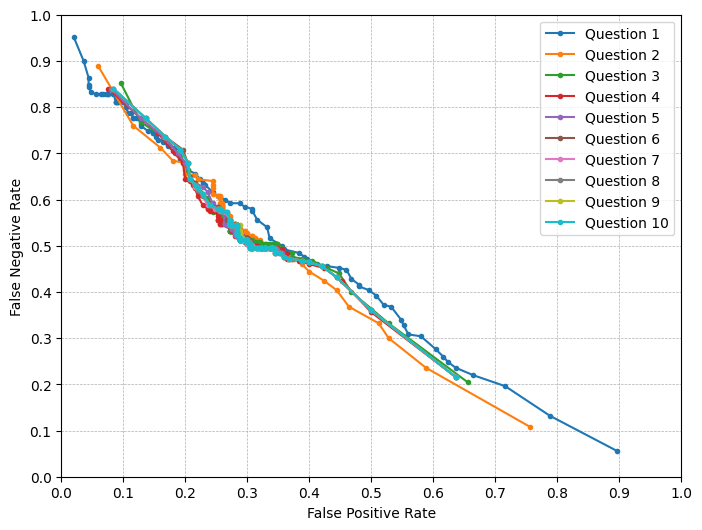

In [38]:
from travel.model.metrics import generate_det_curves

generate_det_curves(accuracy_metrics_by_question_idx, curve_names=[f"Question {question_idx+1}" for question_idx in range(len(accuracy_metrics_by_question_idx))], save_paths=[])

# Analysis on NLI coherence metrics, and disagreements between VLM coherence metrics vs. NLI coherence metrics (8/14/2024)

In [3]:
from collections import defaultdict
from tqdm import tqdm

from travel.model.metrics import question_coherence_metrics_vlm

new_outputs = []
for example_idx, (example_id, output) in tqdm(enumerate(list(preds.items()))):
    output = {'example_id': example_id} | output
    
    coherence_metrics_nli = defaultdict(list)

    vlm_metrics = question_coherence_metrics_vlm([output['success_probs']], [output['success_probs_negated']])
    coherence_metrics_vlm = {}
    coherence_metrics_vlm['relevance_marginal'] = vlm_metrics['relevance_marginal']
    coherence_metrics_vlm['informativeness_marginal'] = vlm_metrics['informativeness_marginal']
    coherence_metrics_vlm['informativeness_marginal_x_relevance_marginal'] = vlm_metrics['informativeness_marginal_x_relevance_marginal']
    
    for question_idx in range(output['final_turn'] + 1):
        
        question = output['questions'][question_idx]
        answer = output['answers'][question_idx]

        relevance = coherence_metrics['metrics_by_turn']['relevance_marginal_by_turn'][example_idx][question_idx]
        informativeness = coherence_metrics['metrics_by_turn']['informativeness_marginal_by_turn'][example_idx][question_idx]
        informativeness_x_relevance = coherence_metrics['metrics_by_turn']['informativeness_marginal_x_relevance_marginal_by_turn'][example_idx][question_idx]
        informativeness_x_relevance_ref = coherence_metrics['metrics_by_turn']['informativeness_marginal_x_relevance_marginal_ref_by_turn'][example_idx][question_idx]      
        informativeness_x_relevance_gain = coherence_metrics['metrics_by_turn']['informativeness_marginal_x_relevance_marginal_ref_gain_by_turn'][example_idx][question_idx]      
        informativeness_x_relevance_reweight = coherence_metrics['metrics_by_turn']['informativeness_marginal_x_relevance_marginal_vlm_reweight_by_turn'][example_idx][question_idx]      
        
        
        coherence_metrics_nli['relevance_marginal'].append(relevance)
        coherence_metrics_nli['informativeness_marginal'].append(informativeness)
        coherence_metrics_nli['informativeness_marginal_x_relevance_marginal'].append(informativeness_x_relevance)
        coherence_metrics_nli['informativeness_marginal_x_relevance_marginal_ref'].append(informativeness_x_relevance_ref)
        coherence_metrics_nli['informativeness_marginal_x_relevance_marginal_ref_gain'].append(informativeness_x_relevance_gain)
        coherence_metrics_nli['informativeness_marginal_x_relevance_marginal_vlm_reweight'].append(informativeness_x_relevance_reweight)
        
        output['coherence_nli'] = coherence_metrics_nli
        output['coherence_vlm'] = coherence_metrics_vlm
        
        
    new_outputs.append(output)

500it [00:00, 924.27it/s] 


In [4]:
import matplotlib.pyplot as plt
import os
from PIL import Image
from pprint import pprint
import random

random_outputs_to_visualize = random.sample(new_outputs, 20)

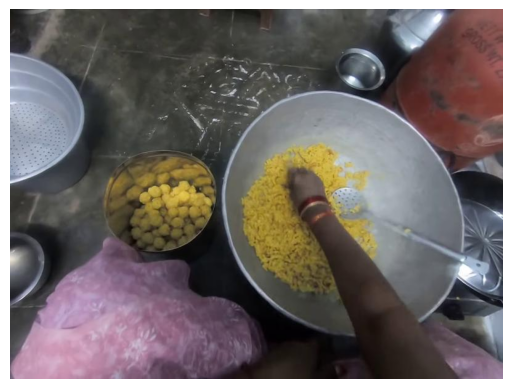

Procedure: Take the paper (mistake: MisalignSRL_ARG1)
['Is the person wearing a lab coat?',
 'Is the person wearing a white lab coat?',
 'Do you see a piece of paper?',
 'Is there a piece of paper?',
 'Do you see a paper?',
 'Is there a paper in the image?']
[{'informativeness': 0.002,
  'informativeness_marginal': 0.059,
  'informativeness_marginal_x_relevance_marginal': 0.003,
  'relevance': 0.036,
  'relevance_marginal': 0.043,
  'rephrased_questions_no': ' The person is not wearing a lab coat.',
  'rephrased_questions_yes': ' The person is wearing a lab coat.'},
 {'informativeness': 0.021,
  'informativeness_marginal': 0.077,
  'informativeness_marginal_x_relevance_marginal': 0.007,
  'relevance': 0.088,
  'relevance_marginal': 0.085,
  'rephrased_questions_no': ' The person is not wearing a white lab coat.',
  'rephrased_questions_yes': ' The person is wearing a white lab coat.'},
 {'informativeness': 0.967,
  'informativeness_marginal': 0.975,
  'informativeness_marginal_x_releva

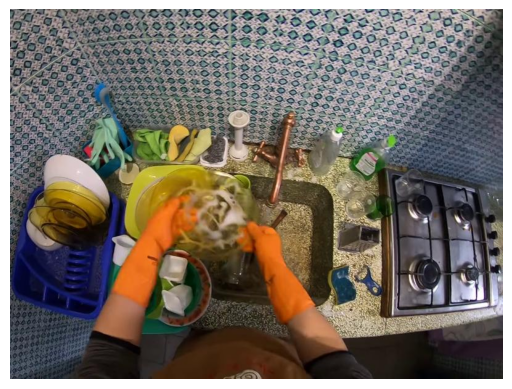

Procedure: Pick another plate (success: None)
['Is the person wearing a lab coat?',
 'Is the person wearing a white lab coat?',
 'Is the person wearing a shirt?',
 'Do you see a plate in the image?',
 'Is there another plate in the image?']
[{'informativeness': 0.304,
  'informativeness_marginal': 0.444,
  'informativeness_marginal_x_relevance_marginal': 0.03,
  'relevance': 0.064,
  'relevance_marginal': 0.068,
  'rephrased_questions_no': ' The person is not wearing a lab coat.',
  'rephrased_questions_yes': ' The person is wearing a lab coat.'},
 {'informativeness': 0.324,
  'informativeness_marginal': 0.428,
  'informativeness_marginal_x_relevance_marginal': 0.008,
  'relevance': 0.058,
  'relevance_marginal': 0.019,
  'rephrased_questions_no': ' The person is not wearing a white lab coat.',
  'rephrased_questions_yes': ' The person is wearing a white lab coat.'},
 {'informativeness': 0.487,
  'informativeness_marginal': 0.54,
  'informativeness_marginal_x_relevance_marginal': 0.02,

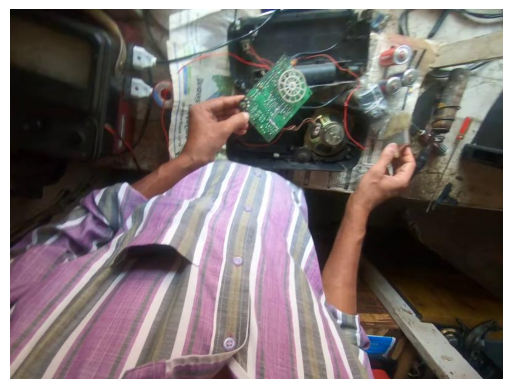

Procedure: Throw brush on table (success: None)
['Is the brush on the table?',
 'Is the person working on a table?',
 'Is the person wearing gloves?',
 'Is the person wearing a white shirt?',
 'Is there a table in the photo?',
 'Is there a table in the image?',
 'Is there a brush in the image?']
[{'informativeness': 0.893,
  'informativeness_marginal': 0.905,
  'informativeness_marginal_x_relevance_marginal': 0.831,
  'relevance': 0.938,
  'relevance_marginal': 0.918,
  'rephrased_questions_no': ' The brush is not on the table.',
  'rephrased_questions_yes': ' The brush is on the table.'},
 {'informativeness': 0.967,
  'informativeness_marginal': 0.975,
  'informativeness_marginal_x_relevance_marginal': 0.031,
  'relevance': 0.033,
  'relevance_marginal': 0.032,
  'rephrased_questions_no': ' The person is not working on a table.',
  'rephrased_questions_yes': ' The person is working on a table.'},
 {'informativeness': 0.202,
  'informativeness_marginal': 0.291,
  'informativeness_margi

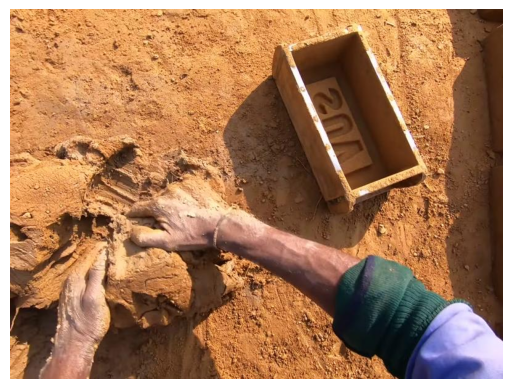

Procedure: Break out a part of the clay hump on the ground (success: None)
['Is the person wearing gloves?',
 'Is the person wearing a white shirt?',
 'Is the person working on the ground?',
 'Is there a clay hump on the ground?']
[{'informativeness': 0.076,
  'informativeness_marginal': 0.034,
  'informativeness_marginal_x_relevance_marginal': 0.002,
  'relevance': 0.069,
  'relevance_marginal': 0.053,
  'rephrased_questions_no': ' The person is not wearing gloves.',
  'rephrased_questions_yes': ' The person is wearing gloves.'},
 {'informativeness': 0.205,
  'informativeness_marginal': 0.225,
  'informativeness_marginal_x_relevance_marginal': 0.031,
  'relevance': 0.113,
  'relevance_marginal': 0.137,
  'rephrased_questions_no': ' The person is not wearing a white shirt.',
  'rephrased_questions_yes': ' The person is wearing a white shirt.'},
 {'informativeness': 0.579,
  'informativeness_marginal': 0.755,
  'informativeness_marginal_x_relevance_marginal': 0.59,
  'relevance': 0.738,

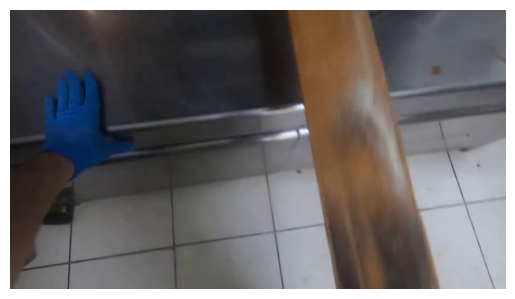

Procedure: Push the wooden plank into the oven (success: None)
['Is the wooden plank in the oven?',
 'Is the person wearing an apron?',
 'Do you see an oven?',
 'Is there an oven?',
 'Is there an oven in the photo?',
 'Is there an oven in the image?']
[{'informativeness': 0.924,
  'informativeness_marginal': 0.908,
  'informativeness_marginal_x_relevance_marginal': 0.878,
  'relevance': 0.975,
  'relevance_marginal': 0.967,
  'rephrased_questions_no': ' The wooden plank is not in the oven.',
  'rephrased_questions_yes': ' The wooden plank is in the oven.'},
 {'informativeness': 0.025,
  'informativeness_marginal': 0.036,
  'informativeness_marginal_x_relevance_marginal': 0.003,
  'relevance': 0.069,
  'relevance_marginal': 0.085,
  'rephrased_questions_no': ' The person is not wearing an apron.',
  'rephrased_questions_yes': ' The person is wearing an apron.'},
 {'informativeness': 0.64,
  'informativeness_marginal': 0.767,
  'informativeness_marginal_x_relevance_marginal': 0.241,
  'r

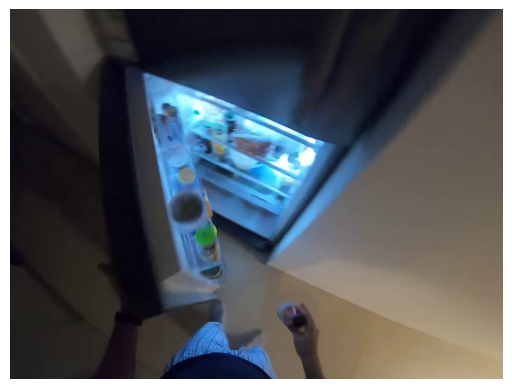

Procedure: Open the fridge (success: None)
['Is the fridge open?',
 'Is the fridge door open?',
 'Is there a fridge in the photo?',
 'Is there a fridge in the image?',
 'Do you see a fridge?']
[{'informativeness': 0.997,
  'informativeness_marginal': 0.998,
  'informativeness_marginal_x_relevance_marginal': 0.982,
  'relevance': 0.976,
  'relevance_marginal': 0.984,
  'rephrased_questions_no': ' The fridge is not open.',
  'rephrased_questions_yes': ' The fridge is open.'},
 {'informativeness': 0.993,
  'informativeness_marginal': 0.993,
  'informativeness_marginal_x_relevance_marginal': 0.019,
  'relevance': 0.012,
  'relevance_marginal': 0.019,
  'rephrased_questions_no': ' The fridge door is closed.',
  'rephrased_questions_yes': ' The fridge door is open.'},
 {'informativeness': 0.819,
  'informativeness_marginal': 0.884,
  'informativeness_marginal_x_relevance_marginal': 0.094,
  'relevance': 0.158,
  'relevance_marginal': 0.107,
  'rephrased_questions_no': ' There is no fridge in

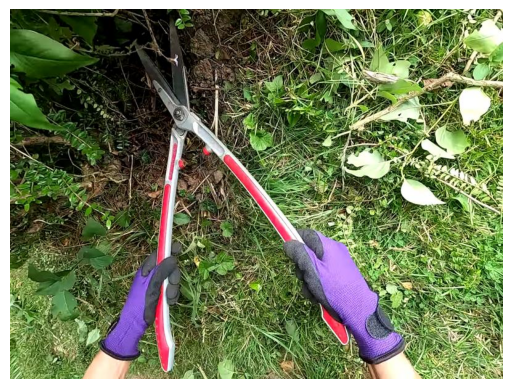

Procedure: Remove the fence branches on the ground (success: None)
['Are the fence branches on the ground?',
 'Is the person wearing any protective gear?',
 'Is the person wearing gloves?',
 'Are there any fence branches on the ground?',
 'Do you see any fence branches on the ground?']
[{'informativeness': 0.345,
  'informativeness_marginal': 0.503,
  'informativeness_marginal_x_relevance_marginal': 0.258,
  'relevance': 0.542,
  'relevance_marginal': 0.512,
  'rephrased_questions_no': ' The fence branches are not on the ground.',
  'rephrased_questions_yes': ' The fence branches are on the ground.'},
 {'informativeness': 0.219,
  'informativeness_marginal': 0.339,
  'informativeness_marginal_x_relevance_marginal': 0.012,
  'relevance': 0.031,
  'relevance_marginal': 0.036,
  'rephrased_questions_no': ' The person is not wearing any protective gear.',
  'rephrased_questions_yes': ' The person is wearing protective gear.'},
 {'informativeness': 0.005,
  'informativeness_marginal': 0.023

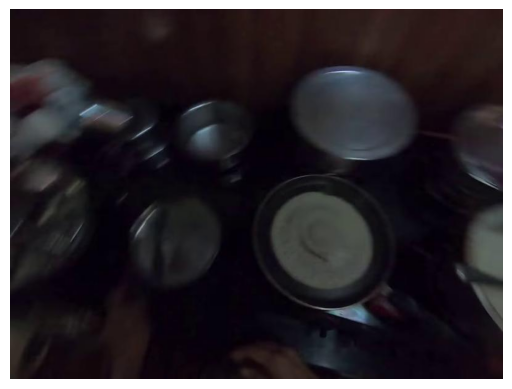

Procedure: Pick spoon from counter (success: None)
['Is the spoon on the counter?',
 'Is the spoon visible in the photo?',
 'Is the person wearing a shirt?',
 'Is the person wearing a white shirt?',
 'Is there a spoon on the counter?',
 'Do you see a spoon?',
 'Is there a spoon in the image?',
 'Is there a spoon?']
[{'informativeness': 0.485,
  'informativeness_marginal': 0.644,
  'informativeness_marginal_x_relevance_marginal': 0.496,
  'relevance': 0.77,
  'relevance_marginal': 0.771,
  'rephrased_questions_no': ' The spoon is not on the counter.',
  'rephrased_questions_yes': ' The spoon is on the counter.'},
 {'informativeness': 0.129,
  'informativeness_marginal': 0.185,
  'informativeness_marginal_x_relevance_marginal': 0.073,
  'relevance': 0.387,
  'relevance_marginal': 0.396,
  'rephrased_questions_no': ' The spoon is not visible in the photo.',
  'rephrased_questions_yes': ' The spoon is visible in the photo.'},
 {'informativeness': 0.676,
  'informativeness_marginal': 0.727,

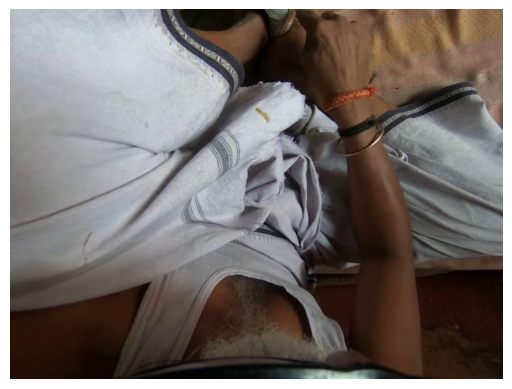

Procedure: Pull the thread on both side of the shoe (success: None)
['Is the person wearing a shoe?',
 'Is the person wearing gloves?',
 'Is the person working on a shoe?',
 'Do you see a shoe?',
 'Do you see a shoe in the image?',
 'Is there a shoe in the image?',
 'Do you see a shoe in the photo?']
[{'informativeness': 0.704,
  'informativeness_marginal': 0.758,
  'informativeness_marginal_x_relevance_marginal': 0.282,
  'relevance': 0.375,
  'relevance_marginal': 0.373,
  'rephrased_questions_no': ' The person is not wearing a shoe.',
  'rephrased_questions_yes': ' The person is wearing a shoe.'},
 {'informativeness': 0.242,
  'informativeness_marginal': 0.298,
  'informativeness_marginal_x_relevance_marginal': 0.008,
  'relevance': 0.011,
  'relevance_marginal': 0.027,
  'rephrased_questions_no': ' The person is not wearing gloves.',
  'rephrased_questions_yes': ' The person is wearing gloves.'},
 {'informativeness': 0.967,
  'informativeness_marginal': 0.979,
  'informativeness_ma

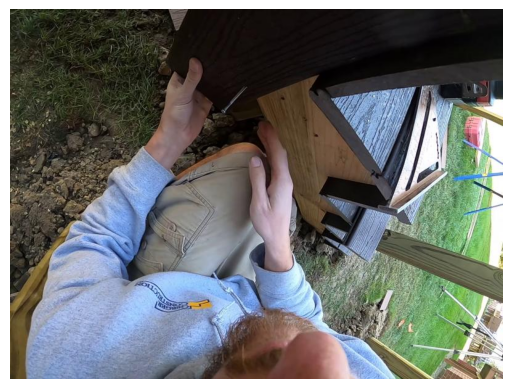

Procedure: Take a drill from the stairs (success: None)
["Is the drill in the person's hand?",
 'Is the person standing on the stairs?',
 'Do you see a drill?',
 'Is there a drill?',
 'Is there a drill in the image?',
 'Do you see stairs?']
[{'informativeness': 0.797,
  'informativeness_marginal': 0.832,
  'informativeness_marginal_x_relevance_marginal': 0.373,
  'relevance': 0.377,
  'relevance_marginal': 0.449,
  'rephrased_questions_no': " The drill is not in the person's hand.",
  'rephrased_questions_yes': " The drill is in the person's hand."},
 {'informativeness': 0.69,
  'informativeness_marginal': 0.744,
  'informativeness_marginal_x_relevance_marginal': 0.013,
  'relevance': 0.043,
  'relevance_marginal': 0.017,
  'rephrased_questions_no': ' The person is not standing on the stairs.',
  'rephrased_questions_yes': ' The person is standing on the stairs.'},
 {'informativeness': 0.979,
  'informativeness_marginal': 0.975,
  'informativeness_marginal_x_relevance_marginal': 0.361,

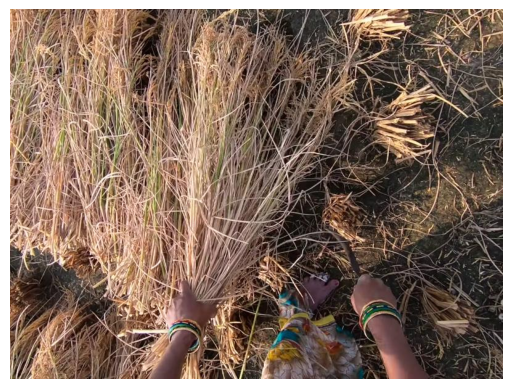

Procedure: Drop the small piece of bread into the frying pan with your hand (mistake: MisalignSRL_ARG1)
["Is the person's hand visible in the photo?",
 'Is the frying pan on the stove?',
 'Is the frying pan on the stovetop?',
 'Do you see a frying pan?',
 'Is there a frying pan?']
[{'informativeness': 0.867,
  'informativeness_marginal': 0.899,
  'informativeness_marginal_x_relevance_marginal': 0.144,
  'relevance': 0.21,
  'relevance_marginal': 0.161,
  'rephrased_questions_no': " The person's hand is not visible in the photo.",
  'rephrased_questions_yes': " The person's hand is visible in the photo."},
 {'informativeness': 0.235,
  'informativeness_marginal': 0.386,
  'informativeness_marginal_x_relevance_marginal': 0.111,
  'relevance': 0.28,
  'relevance_marginal': 0.288,
  'rephrased_questions_no': ' The frying pan is not on the stove.',
  'rephrased_questions_yes': ' The frying pan is on the stove.'},
 {'informativeness': 0.166,
  'informativeness_marginal': 0.289,
  'informativ

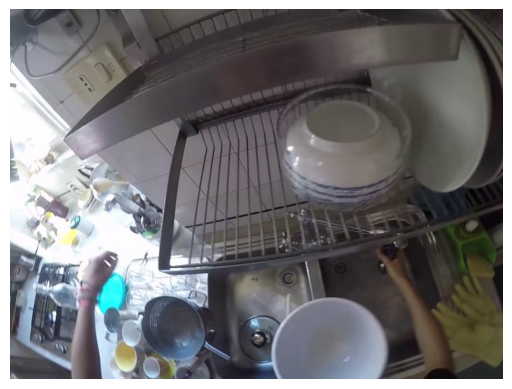

Procedure: Pick a bottle from a kitchen slab with your hand (mistake: Action Incomplete)
['Is the person wearing gloves?',
 "Is the person's hand visible in the photo?",
 'Is the person wearing a glove on their hand?',
 'Do you see a bottle?',
 'Do you see a kitchen slab?',
 'Is there a bottle?']
[{'informativeness': 0.155,
  'informativeness_marginal': 0.295,
  'informativeness_marginal_x_relevance_marginal': 0.008,
  'relevance': 0.028,
  'relevance_marginal': 0.026,
  'rephrased_questions_no': ' The person is not wearing gloves.',
  'rephrased_questions_yes': ' The person is wearing gloves.'},
 {'informativeness': 0.853,
  'informativeness_marginal': 0.89,
  'informativeness_marginal_x_relevance_marginal': 0.142,
  'relevance': 0.215,
  'relevance_marginal': 0.16,
  'rephrased_questions_no': " The person's hand is not visible in the photo.",
  'rephrased_questions_yes': " The person's hand is visible in the photo."},
 {'informativeness': 0.391,
  'informativeness_marginal': 0.534,
 

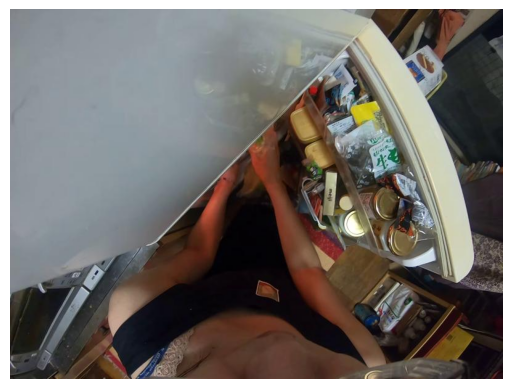

Procedure: Open a fridge with your hand (success: None)
['Is the fridge door open?',
 'Is the fridge open?',
 'Is there a fridge in the photo?',
 'Is there a fridge?',
 'Is there a fridge in the image?']
[{'informativeness': 0.914,
  'informativeness_marginal': 0.92,
  'informativeness_marginal_x_relevance_marginal': 0.151,
  'relevance': 0.156,
  'relevance_marginal': 0.164,
  'rephrased_questions_no': ' The fridge door is closed.',
  'rephrased_questions_yes': ' The fridge door is open.'},
 {'informativeness': 0.989,
  'informativeness_marginal': 0.989,
  'informativeness_marginal_x_relevance_marginal': 0.984,
  'relevance': 0.995,
  'relevance_marginal': 0.996,
  'rephrased_questions_no': ' The fridge is not open.',
  'rephrased_questions_yes': ' The fridge is open.'},
 {'informativeness': 0.934,
  'informativeness_marginal': 0.952,
  'informativeness_marginal_x_relevance_marginal': 0.145,
  'relevance': 0.192,
  'relevance_marginal': 0.152,
  'rephrased_questions_no': ' There is no

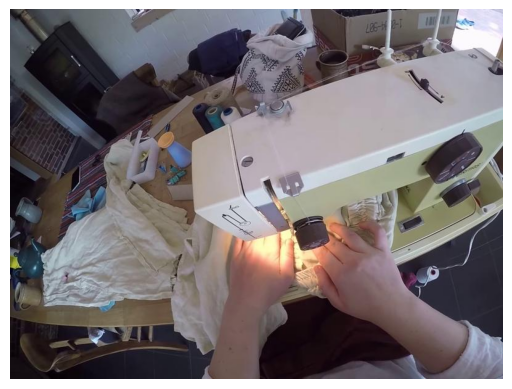

Procedure: Sew the material with the sewing machine on the table (success: None)
['Is the sewing machine on the table?',
 'Is the person working on a sewing machine?',
 'Is there a sewing machine?',
 'Do you see a sewing machine?']
[{'informativeness': 0.934,
  'informativeness_marginal': 0.952,
  'informativeness_marginal_x_relevance_marginal': 0.857,
  'relevance': 0.911,
  'relevance_marginal': 0.901,
  'rephrased_questions_no': ' The sewing machine is not on the table.',
  'rephrased_questions_yes': ' The sewing machine is on the table.'},
 {'informativeness': 0.952,
  'informativeness_marginal': 0.967,
  'informativeness_marginal_x_relevance_marginal': 0.825,
  'relevance': 0.894,
  'relevance_marginal': 0.853,
  'rephrased_questions_no': ' The person is not working on a sewing machine.',
  'rephrased_questions_yes': ' The person is working on a sewing machine.'},
 {'informativeness': 0.989,
  'informativeness_marginal': 0.989,
  'informativeness_marginal_x_relevance_marginal': 0.

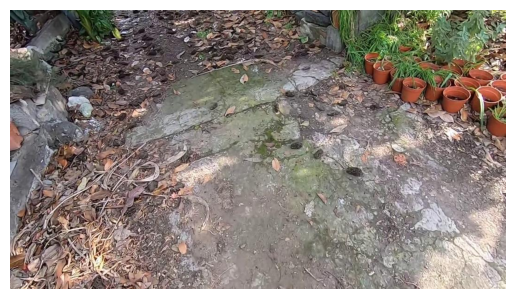

Procedure: Carry shears (success: None)
['Is the person wearing gloves?',
 'Do you see shears in the image?',
 'Do you see shears?']
[{'informativeness': 0.14,
  'informativeness_marginal': 0.263,
  'informativeness_marginal_x_relevance_marginal': 0.001,
  'relevance': 0.007,
  'relevance_marginal': 0.004,
  'rephrased_questions_no': ' The person is not wearing gloves.',
  'rephrased_questions_yes': ' The person is wearing gloves.'},
 {'informativeness': 0.902,
  'informativeness_marginal': 0.905,
  'informativeness_marginal_x_relevance_marginal': 0.703,
  'relevance': 0.761,
  'relevance_marginal': 0.776,
  'rephrased_questions_no': ' There are no shears in the image.',
  'rephrased_questions_yes': ' Yes, there are shears in the image.'},
 {'informativeness': 0.769,
  'informativeness_marginal': 0.771,
  'informativeness_marginal_x_relevance_marginal': 0.58,
  'relevance': 0.736,
  'relevance_marginal': 0.751,
  'rephrased_questions_no': ' You do not see shears.',
  'rephrased_questio

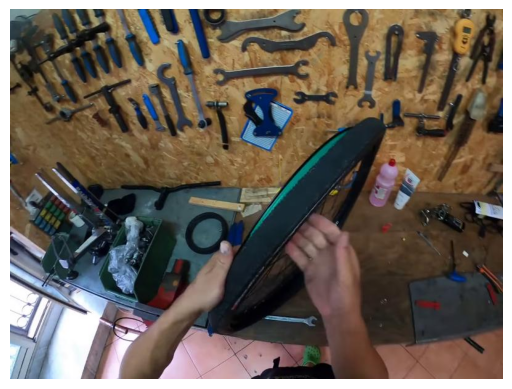

Procedure: Grab the thread (mistake: MisalignSRL_ARG1)
['Is the person wearing gloves?',
 'Is the person wearing a white shirt?',
 'Is the person wearing a shirt?',
 'Do you see a thread?',
 'Is there a thread?',
 'Is there a thread in the photo?',
 'Is there a thread in the image?']
[{'informativeness': 0.151,
  'informativeness_marginal': 0.036,
  'informativeness_marginal_x_relevance_marginal': 0.001,
  'relevance': 0.056,
  'relevance_marginal': 0.034,
  'rephrased_questions_no': ' The person is not wearing gloves.',
  'rephrased_questions_yes': ' The person is wearing gloves.'},
 {'informativeness': 0.092,
  'informativeness_marginal': 0.013,
  'informativeness_marginal_x_relevance_marginal': 0.001,
  'relevance': 0.016,
  'relevance_marginal': 0.057,
  'rephrased_questions_no': ' The person is not wearing a white shirt.',
  'rephrased_questions_yes': ' The person is wearing a white shirt.'},
 {'informativeness': 0.01,
  'informativeness_marginal': 0.027,
  'informativeness_margin

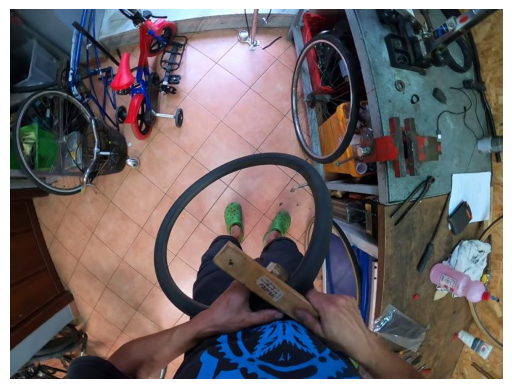

Procedure: Join the wood with the bicycle tube again (success: None)
['Is the bicycle tube made of rubber?',
 'Is the bicycle tube connected to the wood?',
 'Is the person wearing gloves?',
 'Do you see a bicycle tube?',
 'Is there a bicycle tube in the photo?']
[{'informativeness': 0.09,
  'informativeness_marginal': 0.161,
  'informativeness_marginal_x_relevance_marginal': 0.0,
  'relevance': 0.001,
  'relevance_marginal': 0.003,
  'rephrased_questions_no': ' The bicycle tube is not made of rubber.',
  'rephrased_questions_yes': ' The bicycle tube is made of rubber.'},
 {'informativeness': 0.966,
  'informativeness_marginal': 0.952,
  'informativeness_marginal_x_relevance_marginal': 0.939,
  'relevance': 0.982,
  'relevance_marginal': 0.987,
  'rephrased_questions_no': ' The bicycle tube is not connected to the wood.',
  'rephrased_questions_yes': ' The bicycle tube is connected to the wood.'},
 {'informativeness': 0.517,
  'informativeness_marginal': 0.506,
  'informativeness_margin

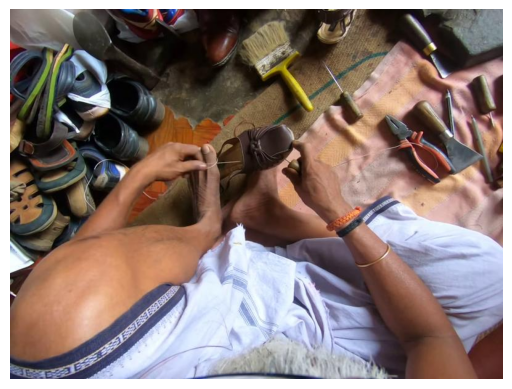

Procedure: Grab the thread (success: None)
['Is the person wearing gloves?',
 'Is the person wearing a white shirt?',
 'Is the person wearing a shirt?',
 'Do you see a thread?',
 'Is there a thread?',
 'Is there a thread in the photo?',
 'Is there a thread in the image?']
[{'informativeness': 0.151,
  'informativeness_marginal': 0.036,
  'informativeness_marginal_x_relevance_marginal': 0.001,
  'relevance': 0.056,
  'relevance_marginal': 0.034,
  'rephrased_questions_no': ' The person is not wearing gloves.',
  'rephrased_questions_yes': ' The person is wearing gloves.'},
 {'informativeness': 0.092,
  'informativeness_marginal': 0.013,
  'informativeness_marginal_x_relevance_marginal': 0.001,
  'relevance': 0.016,
  'relevance_marginal': 0.057,
  'rephrased_questions_no': ' The person is not wearing a white shirt.',
  'rephrased_questions_yes': ' The person is wearing a white shirt.'},
 {'informativeness': 0.01,
  'informativeness_marginal': 0.027,
  'informativeness_marginal_x_relevan

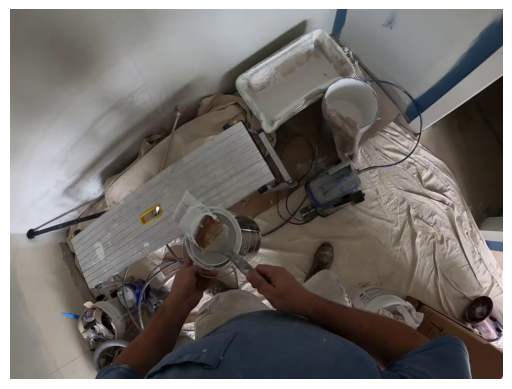

Procedure: Drop the electric screwdriver on the floor with your hand (mistake: MisalignSRL_V_ARG1)
['Is the electric screwdriver on the floor?',
 'Is the person wearing gloves?',
 "Is the electric screwdriver in the person's hand?",
 'Do you see an electric screwdriver?',
 'Is there an electric screwdriver?',
 'Is there an electric screwdriver in the photo?',
 'Is there an electric screwdriver in the image?']
[{'informativeness': 0.69,
  'informativeness_marginal': 0.771,
  'informativeness_marginal_x_relevance_marginal': 0.667,
  'relevance': 0.882,
  'relevance_marginal': 0.865,
  'rephrased_questions_no': ' The electric screwdriver is not on the floor.',
  'rephrased_questions_yes': ' The electric screwdriver is on the floor.'},
 {'informativeness': 0.041,
  'informativeness_marginal': 0.133,
  'informativeness_marginal_x_relevance_marginal': 0.003,
  'relevance': 0.059,
  'relevance_marginal': 0.024,
  'rephrased_questions_no': ' The person is not wearing gloves.',
  'rephrased_que

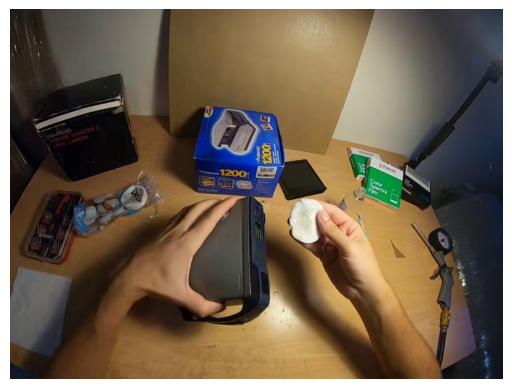

Procedure: Clean the polaroid camera with the wipe (success: None)
['Is the person wearing gloves?',
 'Is the person wearing gloves while cleaning the camera?',
 'Is the person wearing a white shirt?',
 'Do you see a polaroid camera?']
[{'informativeness': 0.062,
  'informativeness_marginal': 0.025,
  'informativeness_marginal_x_relevance_marginal': 0.001,
  'relevance': 0.011,
  'relevance_marginal': 0.049,
  'rephrased_questions_no': ' The person is not wearing gloves.',
  'rephrased_questions_yes': ' The person is wearing gloves.'},
 {'informativeness': 0.366,
  'informativeness_marginal': 0.305,
  'informativeness_marginal_x_relevance_marginal': 0.001,
  'relevance': 0.023,
  'relevance_marginal': 0.002,
  'rephrased_questions_no': ' The person is not wearing gloves while cleaning '
                            'the camera.',
  'rephrased_questions_yes': ' The person is wearing gloves while cleaning the '
                             'camera.'},
 {'informativeness': 0.053,
  'inform

In [5]:
for output in random_outputs_to_visualize:
    
    frame_dir = os.path.join(output['frame_dir'], "frames")
    possible_frame_dirs = [frame_dir.replace("_debug250", f"_partition{i+1}of4") for i in range(4)]
    for pfd in possible_frame_dirs:
        try:
            frame_path = os.path.join(pfd, os.listdir(pfd)[0]) # only a single frame in frame dir
            frame = Image.open(frame_path)
            break
        except:
            continue
    plt.figure()
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    frame.close()

    print(f"Procedure: {output['procedure']} ({'mistake' if output['mistake'] else 'success'}: {output['mistake_type']})")
    for i in range(output['final_turn'] + 1):
        
        pprint(output['candidate_questions'][i])
        pprint(output['candidate_questions_scores'][i])        
        
        print(f"Q{i+1}: {output['questions'][i]}")
        print(f"A{i+1}: {output['answers'][i]} ({output['answer_probs'][i]})")
        print(f"Success probability {i+1}: {output['success_probs'][i]}")
        print("")
        print("Coherence Metrics:")
        print(f"\tMarginal Relevance (NLI): {output['coherence_nli']['relevance_marginal'][i]}")
        print(f"\tMarginal Relevance (VLM): {output['coherence_vlm']['relevance_marginal'][i]}")
        print("")
        print(f"\tMarginal Informativeness (NLI): {output['coherence_nli']['informativeness_marginal'][i]}")
        print(f"\tMarginal Informativeness (VLM): {output['coherence_vlm']['informativeness_marginal'][i]}")
        print("")
        print(f"\tMarginal Relevance x Marginal Informativeness (NLI): {output['coherence_nli']['informativeness_marginal_x_relevance_marginal'][i]}")
        print(f"\tMarginal Relevance x Marginal Informativeness (VLM): {output['coherence_vlm']['informativeness_marginal_x_relevance_marginal'][i]}")
        print("")
        print(f"\tMarginal Relevance x Marginal Informativeness, reference included (NLI): {output['coherence_nli']['informativeness_marginal_x_relevance_marginal_ref'][i]}")
        print(f"\tMarginal Relevance x Marginal Informativeness, cumulative gain (NLI): {output['coherence_nli']['informativeness_marginal_x_relevance_marginal_ref_gain'][i]}")
        print(f"\tMarginal Relevance x Marginal Informativeness, VLM reweighted (NLI): {output['coherence_nli']['informativeness_marginal_x_relevance_marginal_vlm_reweight'][i]}")

        print("\n")
    
    print("\n\n\n")